In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-expression-recognition-dataset


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

In [5]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # Get the number of epochs
    epochs = len(model_history.history['accuracy'])
    epoch_range = range(1, epochs + 1)

    # Plot accuracy
    axs[0].plot(epoch_range, model_history.history['accuracy'])
    axs[0].plot(epoch_range, model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].grid(True)

    # Plot loss
    axs[1].plot(epoch_range, model_history.history['loss'])
    axs[1].plot(epoch_range, model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].grid(True)

    plt.tight_layout()
    fig.savefig('plot.png')
    plt.show()

def check_dataset_structure():
    """
    Check the structure of your dataset to verify paths and count images
    """
    base_path = '/kaggle/input/face-expression-recognition-dataset'

    print("Dataset structure:")
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")


In [6]:
# Check dataset structure first
check_dataset_structure()

# Updated paths for the correct dataset location
base_dataset_path = '/kaggle/input/face-expression-recognition-dataset'

# Common possible paths for this specific dataset:
possible_paths = [
    f'{base_dataset_path}/images/train',
    f'{base_dataset_path}/images/validation',
    f'{base_dataset_path}/train',
    f'{base_dataset_path}/test',
    f'{base_dataset_path}/Training',
    f'{base_dataset_path}/Testing',
    f'{base_dataset_path}/validation',
    f'{base_dataset_path}/val',
    base_dataset_path
]

print("\nChecking possible train/validation paths:")
for path in possible_paths:
    if os.path.exists(path):
        print(f"✓ Found: {path}")
        if os.path.isdir(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if subdirs:
                print(f"  Subdirectories: {subdirs}")
    else:
        print(f"✗ Not found: {path}")

# Also check for CSV files (some datasets come as CSV)
print("\nLooking for CSV files:")
for root, dirs, files in os.walk(base_dataset_path):
    for file in files:
        if file.endswith('.csv'):
            print(f"Found CSV: {os.path.join(root, file)}")

# Set the correct paths based on common patterns
# Update these after running the structure check
train_dir = f'{base_dataset_path}/images/train'
val_dir = f'{base_dataset_path}/images/validation'

# Alternative paths to try if the above don't work:
# train_dir = f'{base_dataset_path}/train'
# val_dir = f'{base_dataset_path}/test'

Dataset structure:
face-expression-recognition-dataset/
  images/
    validation/
      surprise/
        13288.jpg
        24201.jpg
        26556.jpg
        26076.jpg
        27577.jpg
        ... and 792 more files
      fear/
        31973.jpg
        7894.jpg
        32279.jpg
        1075.jpg
        13899.jpg
        ... and 1013 more files
      angry/
        24819.jpg
        30325.jpg
        30273.jpg
        764.jpg
        15979.jpg
        ... and 955 more files
      neutral/
        34530.jpg
        16257.jpg
        8352.jpg
        30371.jpg
        27650.jpg
        ... and 1211 more files
      sad/
        23407.jpg
        29970.jpg
        19674.jpg
        29112.jpg
        8953.jpg
        ... and 1134 more files
      disgust/
        11529.jpg
        25267.jpg
        8948.jpg
        19770.jpg
        7405.jpg
        ... and 106 more files
      happy/
        7737.jpg
        3138.jpg
        5705.jpg
        4640.jpg
        22604.jpg
        ... and 

In [ ]:
# Training parameters
batch_size = 64
num_epoch = 50

# Data augmentation for better training performance
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

print("Model architecture created successfully!")
model.summary()

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Model architecture created successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

Steps per epoch: 450
Validation steps: 110
Training for 50 epochs...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.2425 - loss: 1.8318

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 284s 626ms/step - accuracy: 0.2425 - loss: 1.8318 - val_accuracy: 0.3044 - val_loss: 1.7534
Epoch 2/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:58 530ms/step - accuracy: 0.2188 - loss: 1.7722

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.2188 - loss: 1.7722 - val_accuracy: 0.3034 - val_loss: 1.7547
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 663ms/step - accuracy: 0.2815 - loss: 1.7553 - val_accuracy: 0.3538 - val_loss: 1.6456
Epoch 4/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:56 527ms/step - accuracy: 0.3281 - loss: 1.7244

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3281 - loss: 1.7244 - val_accuracy: 0.3536 - val_loss: 1.6453
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 276s 608ms/step - accuracy: 0.3238 - loss: 1.6919 - val_accuracy: 0.3808 - val_loss: 1.5736
Epoch 6/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:54 522ms/step - accuracy: 0.3281 - loss: 1.7646

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3281 - loss: 1.7646 - val_accuracy: 0.3786 - val_loss: 1.5755
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 654ms/step - accuracy: 0.3581 - loss: 1.6382 - val_accuracy: 0.4304 - val_loss: 1.4991
Epoch 8/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:53 519ms/step - accuracy: 0.2812 - loss: 1.7311

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.2812 - loss: 1.7311 - val_accuracy: 0.4287 - val_loss: 1.5041
Epoch 9/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 699ms/step - accuracy: 0.3789 - loss: 1.5888 - val_accuracy: 0.4484 - val_loss: 1.4525
Epoch 10/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:59 532ms/step - accuracy: 0.3594 - loss: 1.5797

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.3594 - loss: 1.5797 - val_accuracy: 0.4474 - val_loss: 1.4548
Epoch 11/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 321s 715ms/step - accuracy: 0.4014 - loss: 1.5412 - val_accuracy: 0.4756 - val_loss: 1.3855
Epoch 12/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 4:00 535ms/step - accuracy: 0.3438 - loss: 1.5499

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.3438 - loss: 1.5499 - val_accuracy: 0.4749 - val_loss: 1.3872
Epoch 13/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 627ms/step - accuracy: 0.4158 - loss: 1.5004 - val_accuracy: 0.4621 - val_loss: 1.3890
Epoch 14/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:50 514ms/step - accuracy: 0.4688 - loss: 1.3566

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.4688 - loss: 1.3566 - val_accuracy: 0.4648 - val_loss: 1.3858
Epoch 15/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 273s 606ms/step - accuracy: 0.4352 - loss: 1.4647 - val_accuracy: 0.5006 - val_loss: 1.3180
Epoch 16/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:58 532ms/step - accuracy: 0.5156 - loss: 1.2834

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5156 - loss: 1.2834 - val_accuracy: 0.4993 - val_loss: 1.3201
Epoch 17/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 304s 603ms/step - accuracy: 0.4591 - loss: 1.4223 - val_accuracy: 0.5098 - val_loss: 1.2882
Epoch 18/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:47 507ms/step - accuracy: 0.4688 - loss: 1.4974

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.4688 - loss: 1.4974 - val_accuracy: 0.5116 - val_loss: 1.2897
Epoch 19/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 321s 714ms/step - accuracy: 0.4654 - loss: 1.3957 - val_accuracy: 0.5186 - val_loss: 1.2550
Epoch 20/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:48 509ms/step - accuracy: 0.4844 - loss: 1.3697

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4844 - loss: 1.3697 - val_accuracy: 0.5180 - val_loss: 1.2584
Epoch 21/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 626ms/step - accuracy: 0.4773 - loss: 1.3698 - val_accuracy: 0.5332 - val_loss: 1.2263
Epoch 22/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:57 529ms/step - accuracy: 0.5000 - loss: 1.3543

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5000 - loss: 1.3543 - val_accuracy: 0.5320 - val_loss: 1.2255
Epoch 23/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 661ms/step - accuracy: 0.4886 - loss: 1.3421 - val_accuracy: 0.5341 - val_loss: 1.2198
Epoch 24/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:54 522ms/step - accuracy: 0.5000 - loss: 1.2933

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5000 - loss: 1.2933 - val_accuracy: 0.5365 - val_loss: 1.2188
Epoch 25/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 715ms/step - accuracy: 0.4981 - loss: 1.3239 - val_accuracy: 0.5497 - val_loss: 1.1898
Epoch 26/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:57 529ms/step - accuracy: 0.4062 - loss: 1.5443

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.4062 - loss: 1.5443 - val_accuracy: 0.5511 - val_loss: 1.1882
Epoch 27/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 321s 714ms/step - accuracy: 0.5019 - loss: 1.3037 - val_accuracy: 0.5534 - val_loss: 1.1738
Epoch 28/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 4:12 563ms/step - accuracy: 0.5000 - loss: 1.3443

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.5000 - loss: 1.3443 - val_accuracy: 0.5543 - val_loss: 1.1751
Epoch 29/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 308s 595ms/step - accuracy: 0.4999 - loss: 1.3058 - val_accuracy: 0.5562 - val_loss: 1.1739
Epoch 30/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:54 522ms/step - accuracy: 0.5469 - loss: 1.1289

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5469 - loss: 1.1289 - val_accuracy: 0.5547 - val_loss: 1.1766
Epoch 31/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 715ms/step - accuracy: 0.5158 - loss: 1.2693 - val_accuracy: 0.5582 - val_loss: 1.1671
Epoch 32/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:50 513ms/step - accuracy: 0.5625 - loss: 1.0854

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.5625 - loss: 1.0854 - val_accuracy: 0.5592 - val_loss: 1.1644
Epoch 33/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 305s 590ms/step - accuracy: 0.5206 - loss: 1.2659 - val_accuracy: 0.5643 - val_loss: 1.1500
Epoch 34/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:48 509ms/step - accuracy: 0.5312 - loss: 1.2921

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5312 - loss: 1.2921 - val_accuracy: 0.5634 - val_loss: 1.1486
Epoch 35/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 321s 625ms/step - accuracy: 0.5254 - loss: 1.2484 - val_accuracy: 0.5800 - val_loss: 1.1317
Epoch 36/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 4:04 545ms/step - accuracy: 0.5781 - loss: 1.3431

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.5781 - loss: 1.3431 - val_accuracy: 0.5808 - val_loss: 1.1295
Epoch 37/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 716ms/step - accuracy: 0.5281 - loss: 1.2302 - val_accuracy: 0.5749 - val_loss: 1.1175
Epoch 38/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 4:12 561ms/step - accuracy: 0.6094 - loss: 1.0622

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.6094 - loss: 1.0622 - val_accuracy: 0.5756 - val_loss: 1.1188
Epoch 39/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 310s 603ms/step - accuracy: 0.5376 - loss: 1.2215 - val_accuracy: 0.5821 - val_loss: 1.1162
Epoch 40/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 4:29 601ms/step - accuracy: 0.5625 - loss: 1.1269

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5625 - loss: 1.1269 - val_accuracy: 0.5821 - val_loss: 1.1154
Epoch 41/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 647ms/step - accuracy: 0.5376 - loss: 1.2231 - val_accuracy: 0.5764 - val_loss: 1.1143
Epoch 42/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:47 508ms/step - accuracy: 0.6562 - loss: 1.0386

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.6562 - loss: 1.0386 - val_accuracy: 0.5760 - val_loss: 1.1151
Epoch 43/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 715ms/step - accuracy: 0.5406 - loss: 1.2053 - val_accuracy: 0.5797 - val_loss: 1.1140
Epoch 44/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:52 518ms/step - accuracy: 0.5156 - loss: 1.1826

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5156 - loss: 1.1826 - val_accuracy: 0.5811 - val_loss: 1.1112
Epoch 45/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 322s 628ms/step - accuracy: 0.5502 - loss: 1.1955 - val_accuracy: 0.5868 - val_loss: 1.0898
Epoch 46/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:53 519ms/step - accuracy: 0.5938 - loss: 1.0997

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.5938 - loss: 1.0997 - val_accuracy: 0.5895 - val_loss: 1.0890
Epoch 47/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 269s 598ms/step - accuracy: 0.5458 - loss: 1.1950 - val_accuracy: 0.5827 - val_loss: 1.0996
Epoch 48/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:51 515ms/step - accuracy: 0.4688 - loss: 1.2640

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.4688 - loss: 1.2640 - val_accuracy: 0.5825 - val_loss: 1.1008
Epoch 49/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 305s 597ms/step - accuracy: 0.5541 - loss: 1.1833 - val_accuracy: 0.5932 - val_loss: 1.0780
Epoch 50/50
  1/450 ━━━━━━━━━━━━━━━━━━━━ 3:58 532ms/step - accuracy: 0.5781 - loss: 1.1664

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.5781 - loss: 1.1664 - val_accuracy: 0.5942 - val_loss: 1.0773


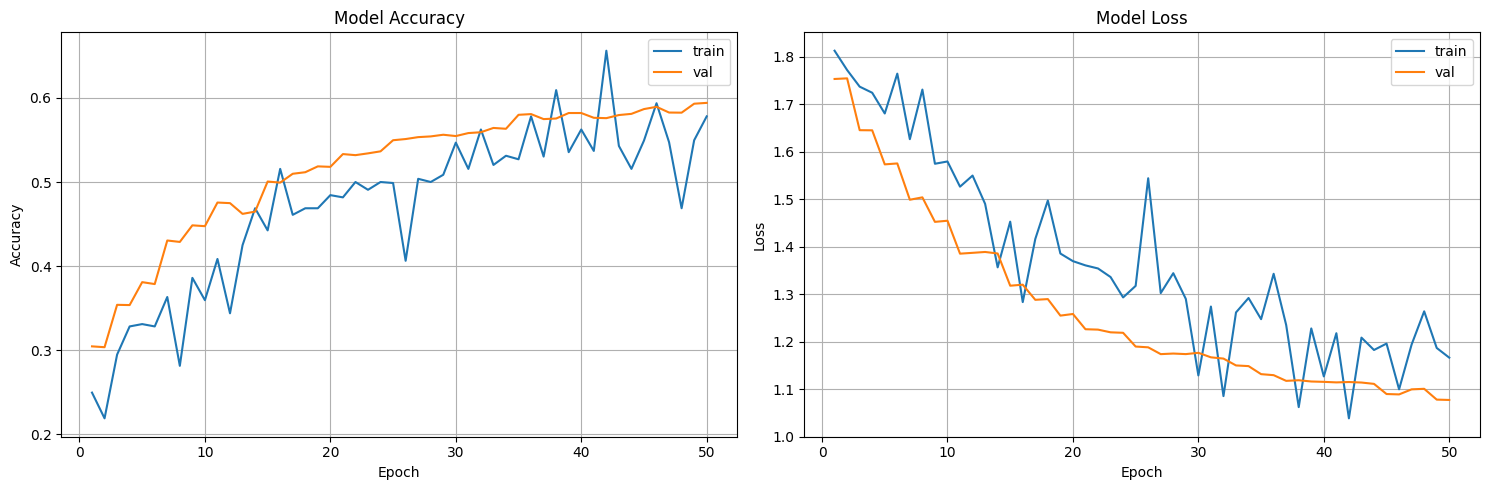

Model saved as 'model50.keras'


In [ ]:
# Compile and train the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Calculate steps per epoch based on actual data
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Training for {num_epoch} epochs...")

# Train the model
model_info = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps)

# Plot training history
plot_model_history(model_info)

# Save the trained model
# model.save_weights('model.weights.h5')

# print("Model saved as 'model.h5'")
model.save('model50.keras')  # ✅ full model
print("Model saved as 'model50.keras'")


In [ ]:
from google.colab import files
files.download('model50.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>